<br />
<!--<div style="text-align: center;"> !-->
<div/>
<font size="7"><b>2値分類モデル と混同マトリックス</b></font>
</div>
<br />

# 参考サイト



In [2]:
# 日本語が使用可能な可視化ライブラリのインストール
!pip install japanize_matplotlib 

    100% |████████████████████████████████| 4.1MB 10.8MB/s ta 0:00:01
  Running setup.py bdist_wheel for japanize-matplotlib ... done
  Stored in directory: /home/ec2-user/.cache/pip/wheels/9c/f9/fc/bc052ce743a03f94ccc7fda73d1d389ce98216c6ffaaf65afc
Successfully built japanize-matplotlib
You are using pip version 10.0.1, however version 20.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


## ライブラリを読み込む

In [3]:
# 各種ライブラリのインポート

# 数値解析・データ分析用ライブラリ
import numpy as np
import pandas as pd

# 可視化ライブラリ
import japanize_matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
%config InlineBackend.figure_formats = {'png', 'retina'}
sns.set(font='IPAexGothic')
sns.set_palette('husl')

# 機械学習ライブラリ
import statsmodels.api as sm 
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer

# おまじない
import warnings
warnings.filterwarnings('ignore')

### ノートブックの結果表示方法を調整

In [4]:
# 表示数を増やす
pd.set_option("display.max_rows", 1000)
pd.set_option('display.float_format', lambda x: '%.3f' % x)

## データの読み込みと表示

### Kaggleデータを読み込む
- csvとして保管されているKaggleデータをノートブック上に読み込みます。

In [5]:
# Kaggleデータの読み込み
dataset = pd.read_csv('./KaggleV2-May-2016.csv',
                      dtype = {'PatientId':'object', 'AppointmentID':'object'}) #IDが数字として
                                                                                #読み込まれないように
    
# AppointmentIDをインデックスに指定
dataset = dataset.set_index('AppointmentID')

## データの中身を見てみよう！

In [6]:
#データの行数、列数を確認
dataset.shape

(110527, 13)

In [7]:
# 先頭10行のみ確認
dataset.head(10)

,PatientId,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,No-show
AppointmentID,,,,,,,,,,,,,
5642903,29872499824296,F,2016-04-29T18:38:08Z,2016-04-29T00:00:00Z,62,JARDIM DA PENHA,0,1,0,0,0,0,No
5642503,558997776694438,M,2016-04-29T16:08:27Z,2016-04-29T00:00:00Z,56,JARDIM DA PENHA,0,0,0,0,0,0,No
5642549,4262962299951,F,2016-04-29T16:19:04Z,2016-04-29T00:00:00Z,62,MATA DA PRAIA,0,0,0,0,0,0,No
5642828,867951213174,F,2016-04-29T17:29:31Z,2016-04-29T00:00:00Z,8,PONTAL DE CAMBURI,0,0,0,0,0,0,No
5642494,8841186448183,F,2016-04-29T16:07:23Z,2016-04-29T00:00:00Z,56,JARDIM DA PENHA,0,1,1,0,0,0,No
5626772,95985133231274,F,2016-04-27T08:36:51Z,2016-04-29T00:00:00Z,76,REPÚBLICA,0,1,0,0,0,0,No
5630279,733688164476661,F,2016-04-27T15:05:12Z,2016-04-29T00:00:00Z,23,GOIABEIRAS,0,0,0,0,0,0,Yes
5630575,3449833394123,F,2016-04-27T15:39:58Z,2016-04-29T00:00:00Z,39,GOIABEIRAS,0,0,0,0,0,0,Yes
5638447,56394729949972,F,2016-04-29T08:02:16Z,2016-04-29T00:00:00Z,21,ANDORINHAS,0,0,0,0,0,0,No


### 日付を文字列から日付型に変換

In [8]:
dataset['ScheduledDay'] = pd.to_datetime(dataset['ScheduledDay'])
dataset['AppointmentDay'] = pd.to_datetime(dataset['AppointmentDay'])

In [9]:
# 先頭10行のみ確認
dataset.head(10)

,PatientId,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,No-show
AppointmentID,,,,,,,,,,,,,
5642903,29872499824296,F,2016-04-29 18:38:08+00:00,2016-04-29 00:00:00+00:00,62,JARDIM DA PENHA,0,1,0,0,0,0,No
5642503,558997776694438,M,2016-04-29 16:08:27+00:00,2016-04-29 00:00:00+00:00,56,JARDIM DA PENHA,0,0,0,0,0,0,No
5642549,4262962299951,F,2016-04-29 16:19:04+00:00,2016-04-29 00:00:00+00:00,62,MATA DA PRAIA,0,0,0,0,0,0,No
5642828,867951213174,F,2016-04-29 17:29:31+00:00,2016-04-29 00:00:00+00:00,8,PONTAL DE CAMBURI,0,0,0,0,0,0,No
5642494,8841186448183,F,2016-04-29 16:07:23+00:00,2016-04-29 00:00:00+00:00,56,JARDIM DA PENHA,0,1,1,0,0,0,No
5626772,95985133231274,F,2016-04-27 08:36:51+00:00,2016-04-29 00:00:00+00:00,76,REPÚBLICA,0,1,0,0,0,0,No
5630279,733688164476661,F,2016-04-27 15:05:12+00:00,2016-04-29 00:00:00+00:00,23,GOIABEIRAS,0,0,0,0,0,0,Yes
5630575,3449833394123,F,2016-04-27 15:39:58+00:00,2016-04-29 00:00:00+00:00,39,GOIABEIRAS,0,0,0,0,0,0,Yes
5638447,56394729949972,F,2016-04-29 08:02:16+00:00,2016-04-29 00:00:00+00:00,21,ANDORINHAS,0,0,0,0,0,0,No


### No-showの数を確認

In [10]:
dataset['No-show'].value_counts(dropna=False).to_frame()

,No-show
No,88208
Yes,22319


### ScheduledDayにだけ時間情報が入っているので、そこを調整

In [11]:
dataset['ScheduledDayStr'] = pd.DataFrame(dataset['ScheduledDay'].apply(lambda x: x.strftime('%Y-%m-%d')), 
                                          index = dataset.index)
# 先頭10行のみ確認
dataset.head(10)

,PatientId,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,No-show,ScheduledDayStr
AppointmentID,,,,,,,,,,,,,,
5642903,29872499824296,F,2016-04-29 18:38:08+00:00,2016-04-29 00:00:00+00:00,62,JARDIM DA PENHA,0,1,0,0,0,0,No,2016-04-29
5642503,558997776694438,M,2016-04-29 16:08:27+00:00,2016-04-29 00:00:00+00:00,56,JARDIM DA PENHA,0,0,0,0,0,0,No,2016-04-29
5642549,4262962299951,F,2016-04-29 16:19:04+00:00,2016-04-29 00:00:00+00:00,62,MATA DA PRAIA,0,0,0,0,0,0,No,2016-04-29
5642828,867951213174,F,2016-04-29 17:29:31+00:00,2016-04-29 00:00:00+00:00,8,PONTAL DE CAMBURI,0,0,0,0,0,0,No,2016-04-29
5642494,8841186448183,F,2016-04-29 16:07:23+00:00,2016-04-29 00:00:00+00:00,56,JARDIM DA PENHA,0,1,1,0,0,0,No,2016-04-29
5626772,95985133231274,F,2016-04-27 08:36:51+00:00,2016-04-29 00:00:00+00:00,76,REPÚBLICA,0,1,0,0,0,0,No,2016-04-27
5630279,733688164476661,F,2016-04-27 15:05:12+00:00,2016-04-29 00:00:00+00:00,23,GOIABEIRAS,0,0,0,0,0,0,Yes,2016-04-27
5630575,3449833394123,F,2016-04-27 15:39:58+00:00,2016-04-29 00:00:00+00:00,39,GOIABEIRAS,0,0,0,0,0,0,Yes,2016-04-27
5638447,56394729949972,F,2016-04-29 08:02:16+00:00,2016-04-29 00:00:00+00:00,21,ANDORINHAS,0,0,0,0,0,0,No,2016-04-29


### No-showを数値に変換

In [12]:
dataset['No-Show-Int'] = dataset['No-show'].apply(lambda x: 1 if x == 'Yes' else 0)

# 先頭30行のみ確認
dataset.head(30)

,PatientId,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,No-show,ScheduledDayStr,No-Show-Int
AppointmentID,,,,,,,,,,,,,,,
5642903,29872499824296,F,2016-04-29 18:38:08+00:00,2016-04-29 00:00:00+00:00,62,JARDIM DA PENHA,0,1,0,0,0,0,No,2016-04-29,0
5642503,558997776694438,M,2016-04-29 16:08:27+00:00,2016-04-29 00:00:00+00:00,56,JARDIM DA PENHA,0,0,0,0,0,0,No,2016-04-29,0
5642549,4262962299951,F,2016-04-29 16:19:04+00:00,2016-04-29 00:00:00+00:00,62,MATA DA PRAIA,0,0,0,0,0,0,No,2016-04-29,0
5642828,867951213174,F,2016-04-29 17:29:31+00:00,2016-04-29 00:00:00+00:00,8,PONTAL DE CAMBURI,0,0,0,0,0,0,No,2016-04-29,0
5642494,8841186448183,F,2016-04-29 16:07:23+00:00,2016-04-29 00:00:00+00:00,56,JARDIM DA PENHA,0,1,1,0,0,0,No,2016-04-29,0
5626772,95985133231274,F,2016-04-27 08:36:51+00:00,2016-04-29 00:00:00+00:00,76,REPÚBLICA,0,1,0,0,0,0,No,2016-04-27,0
5630279,733688164476661,F,2016-04-27 15:05:12+00:00,2016-04-29 00:00:00+00:00,23,GOIABEIRAS,0,0,0,0,0,0,Yes,2016-04-27,1
5630575,3449833394123,F,2016-04-27 15:39:58+00:00,2016-04-29 00:00:00+00:00,39,GOIABEIRAS,0,0,0,0,0,0,Yes,2016-04-27,1
5638447,56394729949972,F,2016-04-29 08:02:16+00:00,2016-04-29 00:00:00+00:00,21,ANDORINHAS,0,0,0,0,0,0,No,2016-04-29,0


### ScheduledDayとAppointmentDayの差（来院までの日数）を計算

In [13]:
# 日時の差を取る
d = dataset['AppointmentDay'] - dataset['ScheduledDay']
# この結果から日付情報だけ取り出して、マイナスにならないように1日分足す
dataset['Days'] = pd.DataFrame(d.apply(lambda x: x.days + 1), index = dataset.index)

### 来院までの日数とNow-show率の関係を確認

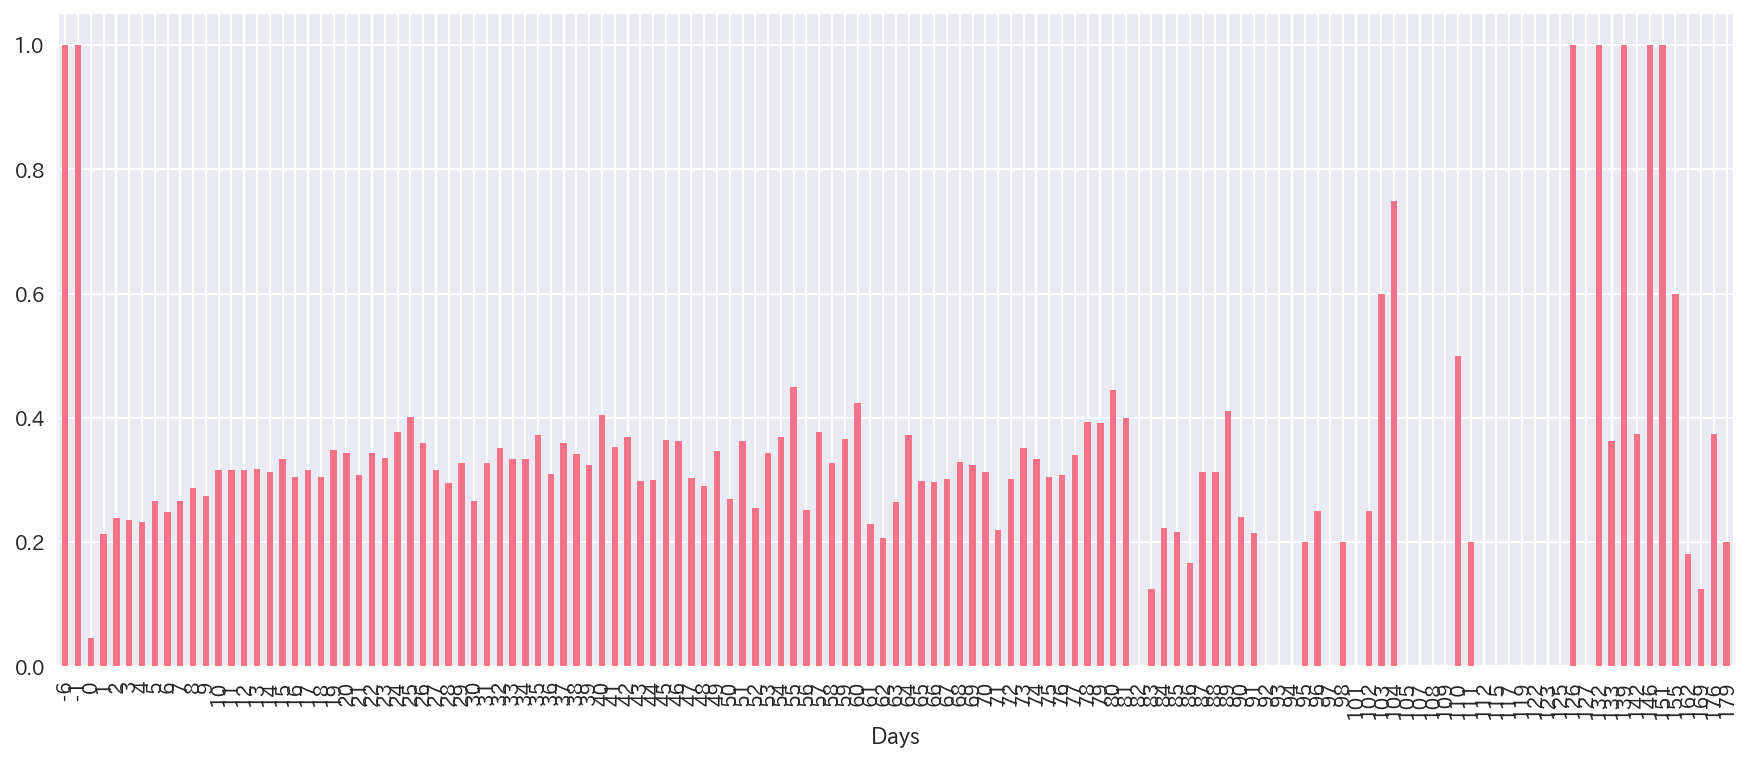

In [14]:
dataset['No-Show-Int'].groupby(dataset['Days']).mean().plot(kind="bar", figsize=(15, 6))

なぜか来院までの日数がマイナスの異常なレコードがあるので後で削除する

### 年齢とNow-show率の関係を確認

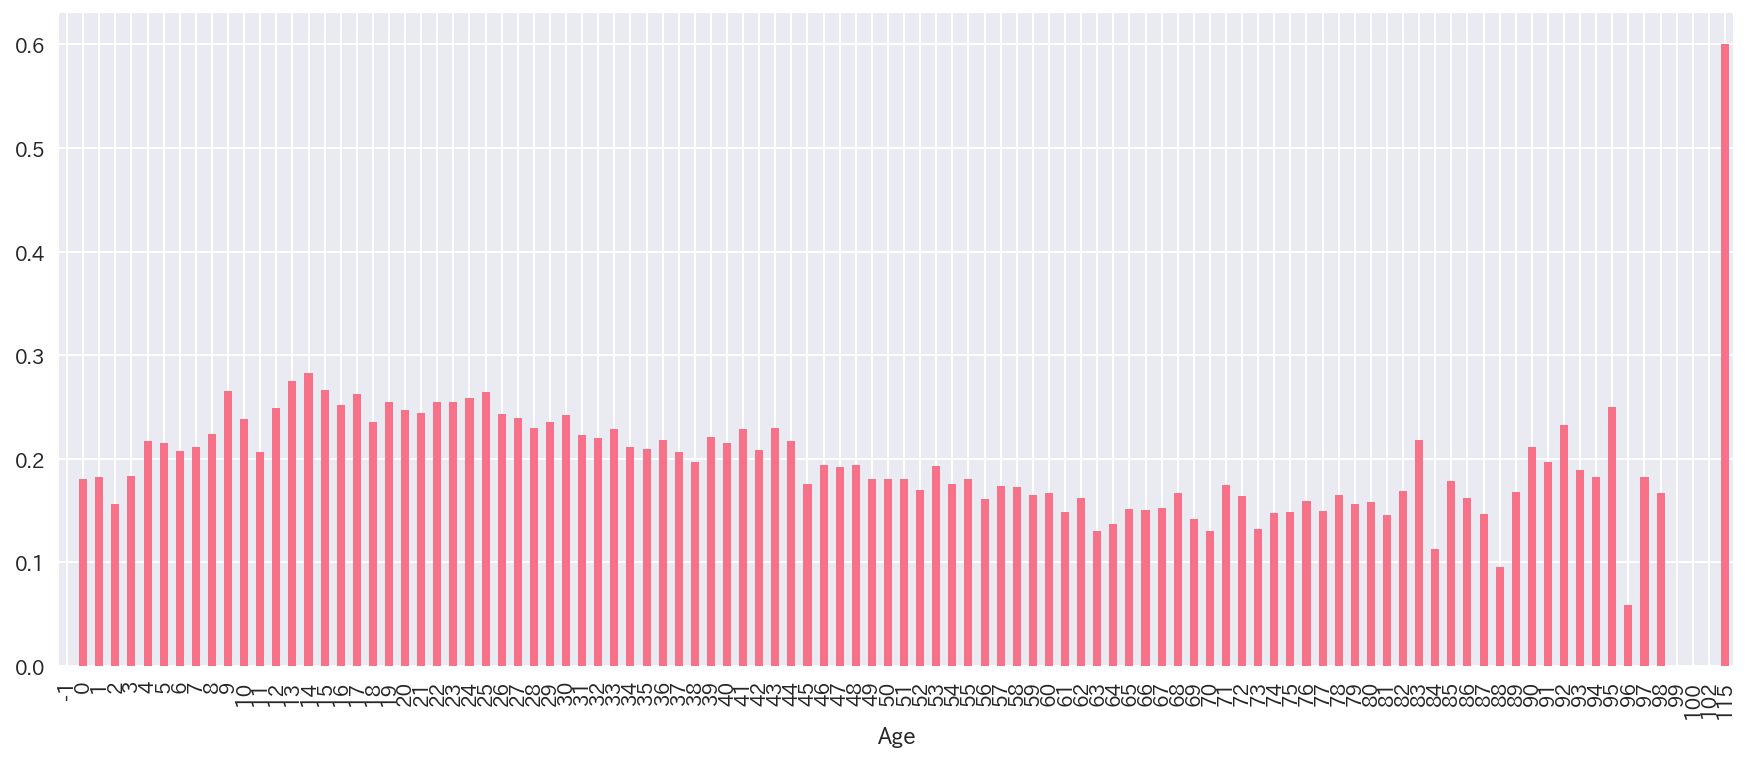

In [22]:
dataset['No-Show-Int'].groupby(dataset['Age']).mean().plot(kind="bar", figsize=(15, 6))

### 100歳以上を確認

In [15]:
dataset[dataset['Age'] > 100]

,PatientId,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,No-show,ScheduledDayStr,No-Show-Int,Days
AppointmentID,,,,,,,,,,,,,,,,
5651757,976294799775439,F,2016-05-03 09:14:53+00:00,2016-05-03 00:00:00+00:00,102,CONQUISTA,0,0,0,0,0,0,No,2016-05-03,0,0
5700278,31963211613981,F,2016-05-16 09:17:44+00:00,2016-05-19 00:00:00+00:00,115,ANDORINHAS,0,0,0,0,1,0,Yes,2016-05-16,1,3
5700279,31963211613981,F,2016-05-16 09:17:44+00:00,2016-05-19 00:00:00+00:00,115,ANDORINHAS,0,0,0,0,1,0,Yes,2016-05-16,1,3
5562812,31963211613981,F,2016-04-08 14:29:17+00:00,2016-05-16 00:00:00+00:00,115,ANDORINHAS,0,0,0,0,1,0,Yes,2016-04-08,1,38
5744037,31963211613981,F,2016-05-30 09:44:51+00:00,2016-05-30 00:00:00+00:00,115,ANDORINHAS,0,0,0,0,1,0,No,2016-05-30,0,0
5751563,234283596548,F,2016-05-31 10:19:49+00:00,2016-06-02 00:00:00+00:00,102,MARIA ORTIZ,0,0,0,0,0,0,No,2016-05-31,0,2
5717451,748234579244724,F,2016-05-19 07:57:56+00:00,2016-06-03 00:00:00+00:00,115,SÃO JOSÉ,0,1,0,0,0,1,No,2016-05-19,0,15



### PatientIdが 31963211613981 の患者を除外

In [16]:
dataset_clean = dataset.drop(dataset.index[dataset['PatientId'] == '31963211613981'])

In [17]:
dataset_clean[dataset_clean['Age'] > 100]

,PatientId,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,No-show,ScheduledDayStr,No-Show-Int,Days
AppointmentID,,,,,,,,,,,,,,,,
5651757,976294799775439,F,2016-05-03 09:14:53+00:00,2016-05-03 00:00:00+00:00,102,CONQUISTA,0,0,0,0,0,0,No,2016-05-03,0,0
5751563,234283596548,F,2016-05-31 10:19:49+00:00,2016-06-02 00:00:00+00:00,102,MARIA ORTIZ,0,0,0,0,0,0,No,2016-05-31,0,2
5717451,748234579244724,F,2016-05-19 07:57:56+00:00,2016-06-03 00:00:00+00:00,115,SÃO JOSÉ,0,1,0,0,0,1,No,2016-05-19,0,15


# データ集計開始！

## 念のため欠損値を確認

In [18]:
pd.DataFrame(dataset_clean.isnull().sum())

,0
PatientId,0
Gender,0
ScheduledDay,0
AppointmentDay,0
Age,0
Neighbourhood,0
Scholarship,0
Hipertension,0
Diabetes,0
Alcoholism,0


### 負の値（異常値）を持つサンプルを確認

In [19]:
dataset_clean[dataset['Age'] < 0]

,PatientId,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,No-show,ScheduledDayStr,No-Show-Int,Days
AppointmentID,,,,,,,,,,,,,,,,
5775010,465943158731293,F,2016-06-06 08:58:13+00:00,2016-06-06 00:00:00+00:00,-1,ROMÃO,0,0,0,0,0,0,No,2016-06-06,0,0


### 負の値を除くデータセット作成

In [20]:
dataset_clean = dataset_clean[dataset['Age'] >= 0]

### 負の値（異常値）を持つサンプルを確認

In [21]:
dataset_clean[dataset_clean['Days'] < 0]

,PatientId,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,No-show,ScheduledDayStr,No-Show-Int,Days
AppointmentID,,,,,,,,,,,,,,,,
5679978,7839272661752,M,2016-05-10 10:51:53+00:00,2016-05-09 00:00:00+00:00,38,RESISTÊNCIA,0,0,0,0,1,0,Yes,2016-05-10,1,-1
5715660,7896293967868,F,2016-05-18 14:50:41+00:00,2016-05-17 00:00:00+00:00,19,SANTO ANTÔNIO,0,0,0,0,1,0,Yes,2016-05-18,1,-1
5664962,24252258389979,F,2016-05-05 13:43:58+00:00,2016-05-04 00:00:00+00:00,22,CONSOLAÇÃO,0,0,0,0,0,0,Yes,2016-05-05,1,-1
5686628,998231581612122,F,2016-05-11 13:49:20+00:00,2016-05-05 00:00:00+00:00,81,SANTO ANTÔNIO,0,0,0,0,0,0,Yes,2016-05-11,1,-6
5655637,3787481966821,M,2016-05-04 06:50:57+00:00,2016-05-03 00:00:00+00:00,7,TABUAZEIRO,0,0,0,0,0,0,Yes,2016-05-04,1,-1


### 負の値を除く

In [22]:
dataset_clean = dataset_clean[dataset_clean['Days'] >= 0]

# 先頭10行のみ確認
dataset_clean.head(10)

,PatientId,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,No-show,ScheduledDayStr,No-Show-Int,Days
AppointmentID,,,,,,,,,,,,,,,,
5642903,29872499824296,F,2016-04-29 18:38:08+00:00,2016-04-29 00:00:00+00:00,62,JARDIM DA PENHA,0,1,0,0,0,0,No,2016-04-29,0,0
5642503,558997776694438,M,2016-04-29 16:08:27+00:00,2016-04-29 00:00:00+00:00,56,JARDIM DA PENHA,0,0,0,0,0,0,No,2016-04-29,0,0
5642549,4262962299951,F,2016-04-29 16:19:04+00:00,2016-04-29 00:00:00+00:00,62,MATA DA PRAIA,0,0,0,0,0,0,No,2016-04-29,0,0
5642828,867951213174,F,2016-04-29 17:29:31+00:00,2016-04-29 00:00:00+00:00,8,PONTAL DE CAMBURI,0,0,0,0,0,0,No,2016-04-29,0,0
5642494,8841186448183,F,2016-04-29 16:07:23+00:00,2016-04-29 00:00:00+00:00,56,JARDIM DA PENHA,0,1,1,0,0,0,No,2016-04-29,0,0
5626772,95985133231274,F,2016-04-27 08:36:51+00:00,2016-04-29 00:00:00+00:00,76,REPÚBLICA,0,1,0,0,0,0,No,2016-04-27,0,2
5630279,733688164476661,F,2016-04-27 15:05:12+00:00,2016-04-29 00:00:00+00:00,23,GOIABEIRAS,0,0,0,0,0,0,Yes,2016-04-27,1,2
5630575,3449833394123,F,2016-04-27 15:39:58+00:00,2016-04-29 00:00:00+00:00,39,GOIABEIRAS,0,0,0,0,0,0,Yes,2016-04-27,1,2
5638447,56394729949972,F,2016-04-29 08:02:16+00:00,2016-04-29 00:00:00+00:00,21,ANDORINHAS,0,0,0,0,0,0,No,2016-04-29,0,0


### 基礎統計値を確認

In [23]:
dataset_clean.describe()

,Age,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,No-Show-Int,Days
count,110517.000,110517.000,110517.000,110517.000,110517.000,110517.000,110517.000,110517.000,110517.000
mean,37.087,0.098,0.197,0.072,0.030,0.022,0.321,0.202,10.184
std,23.106,0.298,0.398,0.258,0.172,0.161,0.467,0.401,15.255
min,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
25%,18.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
50%,37.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,4.000
75%,55.000,0.000,0.000,0.000,0.000,0.000,1.000,0.000,15.000
max,115.000,1.000,1.000,1.000,1.000,4.000,1.000,1.000,179.000


# モデル構築用データセットの作成

In [24]:
# モデル構築用データセットの作成
x_clms_num = ['Age', 'Scholarship', 'Hipertension', 'Diabetes', 'Alcoholism', 'Handcap', 
          'SMS_received', 'Days']

modeling_dataset = dataset_clean[['No-Show-Int', 'Gender'] + x_clms_num]

# カテゴリ変数のダミー変数化
modeling_dataset = pd.get_dummies(modeling_dataset)

x_clms = ['Gender_F', 'Gender_F'] + x_clms_num

modeling_dataset.head(10)

,No-Show-Int,Age,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,Days,Gender_F,Gender_M
AppointmentID,,,,,,,,,,,
5642903,0,62,0,1,0,0,0,0,0,1,0
5642503,0,56,0,0,0,0,0,0,0,0,1
5642549,0,62,0,0,0,0,0,0,0,1,0
5642828,0,8,0,0,0,0,0,0,0,1,0
5642494,0,56,0,1,1,0,0,0,0,1,0
5626772,0,76,0,1,0,0,0,0,2,1,0
5630279,1,23,0,0,0,0,0,0,2,1,0
5630575,1,39,0,0,0,0,0,0,2,1,0
5638447,0,21,0,0,0,0,0,0,0,1,0


# ロジスティックス回帰による分析結果を見る

In [25]:
# モデリング用データセットの作成
X = modeling_dataset[x_clms]
y= modeling_dataset['No-Show-Int']

In [26]:
#7:3の割合で学習データとテストデータに分割する
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

In [27]:
# ロジスティック回帰でモデル化
lrc = LogisticRegression(random_state=0)
result = lrc.fit(X_train, y_train)

In [28]:
# 学習したモデルをもとに予測
pred = result.predict(X_test)

# 先頭30行のみ確認
print(pred[0:30])

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 1]


In [29]:
# スコアと混合行列
y_pred_train = lrc.predict(X_train)
df_train_score = pd.DataFrame(dict(Accuracy=[accuracy_score(y_train, y_pred_train)], 
                                Precision=[precision_score(y_train, y_pred_train)], 
                                Recall=[recall_score(y_train, y_pred_train)],
                                F1=[f1_score(y_train, y_pred_train)])).T
df_train_score = df_train_score.rename(columns={0:'Train'})

y_pred_test = lrc.predict(X_test)
df_test_score = pd.DataFrame(dict(Accuracy=[accuracy_score(y_test, y_pred_test)], 
                                Precision=[precision_score(y_test, y_pred_test)], 
                                Recall=[recall_score(y_test, y_pred_test)],
                                F1=[f1_score(y_test, y_pred_test)])).T
df_test_score = df_test_score.rename(columns={0:'Test'})

# スコア比較用データフレーム作成
df_train_score.join(df_test_score)

,Train,Test
Accuracy,0.795,0.795
Precision,0.349,0.301
Recall,0.017,0.016
F1,0.032,0.031


### 混同マトリックス（Train）

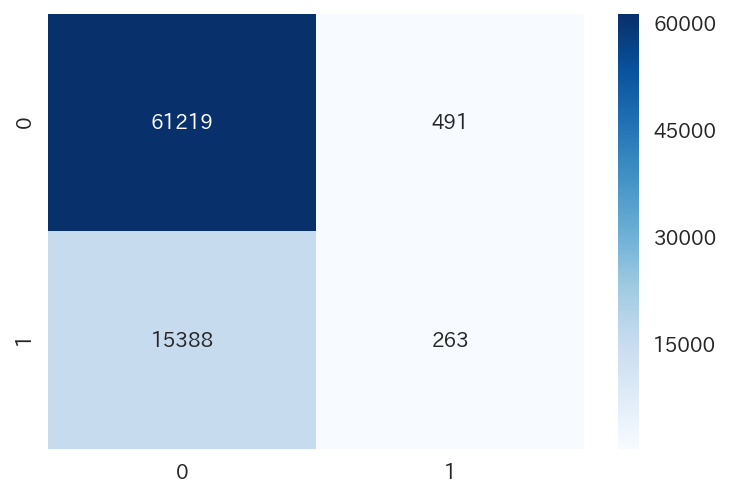

In [30]:
sns.heatmap(confusion_matrix(y_train, y_pred_train), annot=True, fmt='d', cmap='Blues')
plt.show()

### 混同マトリックス（Test）

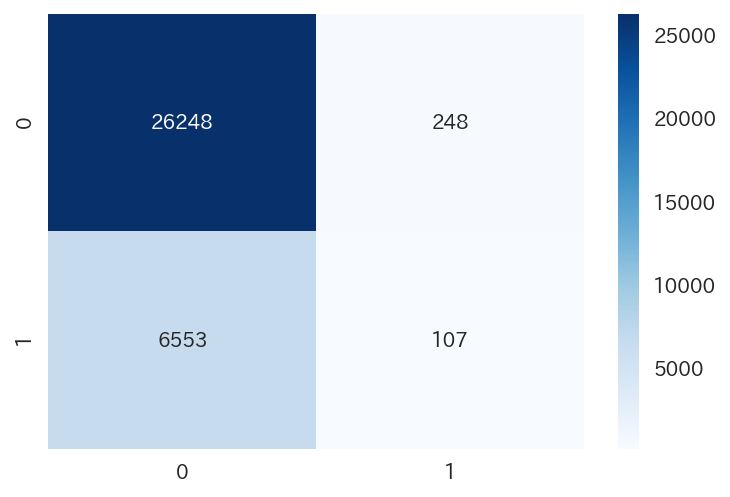

In [31]:
sns.heatmap(confusion_matrix(y_test, y_pred_test), annot=True, fmt='d', cmap='Blues')
plt.show()

# ランダムフォレストによる分析結果を見る

In [32]:
forest = RandomForestClassifier(random_state=0)
forest.fit(X_train, y_train)

y_pred_train = forest.predict(X_train)
df_train_score = pd.DataFrame(dict(Accuracy=[accuracy_score(y_train, y_pred_train)], 
                                Precision=[precision_score(y_train, y_pred_train)], 
                                Recall=[recall_score(y_train, y_pred_train)],
                                F1=[f1_score(y_train, y_pred_train)])).T
df_train_score = df_train_score.rename(columns={0:'Train'})

y_pred_test = forest.predict(X_test)
df_test_score = pd.DataFrame(dict(Accuracy=[accuracy_score(y_test, y_pred_test)], 
                                Precision=[precision_score(y_test, y_pred_test)], 
                                Recall=[recall_score(y_test, y_pred_test)],
                                F1=[f1_score(y_test, y_pred_test)])).T
df_test_score = df_test_score.rename(columns={0:'Test'})

# スコア比較用データフレーム作成
df_train_score.join(df_test_score)

,Train,Test
Accuracy,0.866,0.763
Precision,0.776,0.347
Recall,0.475,0.204
F1,0.589,0.257


### 混同マトリックス（Train）

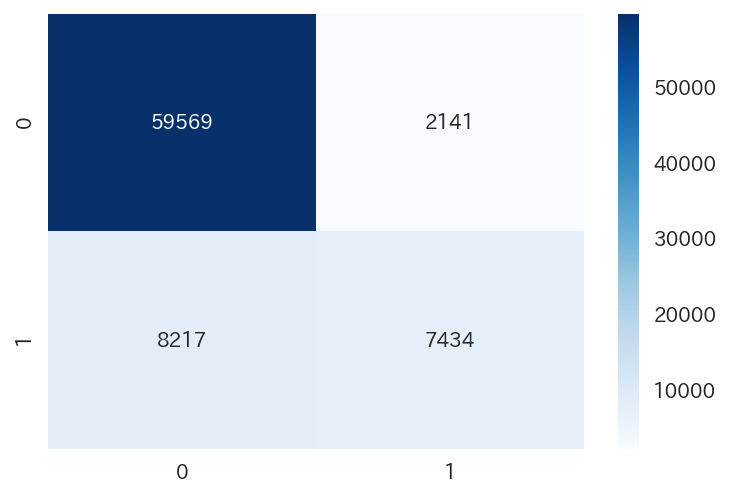

In [33]:
sns.heatmap(confusion_matrix(y_train, y_pred_train), annot=True, fmt='d', cmap='Blues')
plt.show()

### 混同マトリックス（Test）

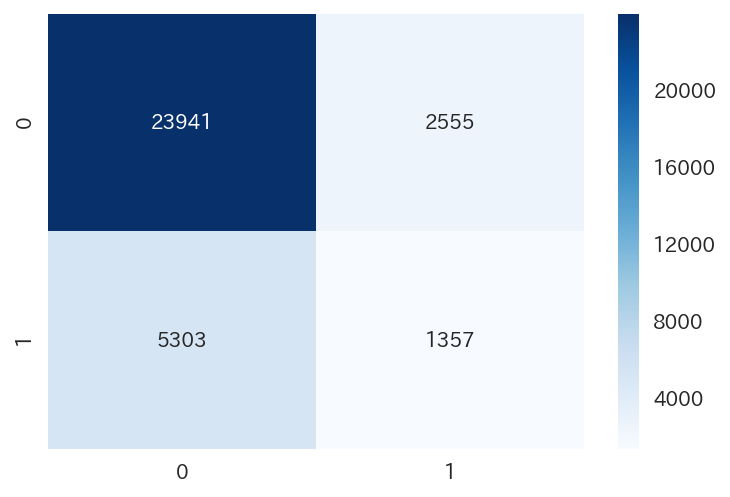

In [34]:
sns.heatmap(confusion_matrix(y_test, y_pred_test), annot=True, fmt='d', cmap='Blues')
plt.show()

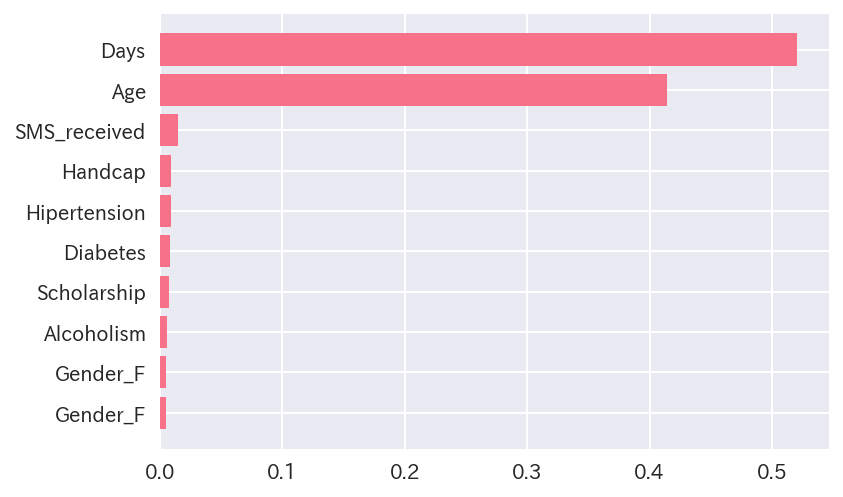

In [35]:
values, names = zip(*sorted(zip(forest.feature_importances_, X.columns)))

plt.barh(range(len(names)), values, align='center')
plt.yticks(range(len(names)), names)
plt.show()

#### 今回作成したデータセットをcsvに出力し、保存する

In [36]:
modeling_dataset.to_csv('./train_dataset_classify.csv')

# SageMakerによるランダムフォレスト

In [39]:
Xy_train = X_train.copy()
Xy_train['target'] = y_train

Xy_test = X_test.copy()
Xy_test['target'] = y_test

In [40]:
Xy_train.head()

,Gender_F,Gender_F,Age,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,Days,target
AppointmentID,,,,,,,,,,,
5613521,0,0,12,0,0,0,0,0,1,11,0
5722613,1,1,36,0,0,1,1,0,1,11,1
5685465,1,1,50,0,0,0,0,0,0,0,0
5632166,1,1,66,0,1,0,0,0,1,8,0
5646180,0,0,13,0,0,0,0,0,0,0,0


In [41]:
Xy_test.head()

,Gender_F,Gender_F,Age,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,Days,target
AppointmentID,,,,,,,,,,,
5614626,1,1,18,0,0,0,0,0,1,8,0
5668360,1,1,53,0,1,0,0,0,1,19,0
5681850,1,1,1,0,0,0,0,0,0,0,0
5709156,1,1,8,0,0,0,0,0,0,2,0
5592987,1,1,40,1,1,0,0,0,1,42,1


In [42]:
Xy_train.to_csv('kaggle-train.csv')
Xy_test.to_csv('kaggle-test.csv')

In [44]:
import boto3
from sagemaker import get_execution_role
import sagemaker
from sklearn.model_selection import train_test_split
from sklearn.datasets import load_boston

sm_boto3 = boto3.client('sagemaker')
sess = sagemaker.Session()
region = sess.boto_session.region_name
bucket = sess.default_bucket() # this could also be a hard-coded bucket name

print('Using bucket ' + bucket)

Using bucket sagemaker-ap-northeast-1-208274468343


In [45]:
# send data to S3. SageMaker will take training data from s3
trainpath = sess.upload_data(
    path='kaggle-train.csv', bucket=bucket,
    key_prefix='sagemaker_kaggle/sklearncontainer')

testpath = sess.upload_data(
    path='kaggle-test.csv', bucket=bucket,
    key_prefix='sagemaker_kaggle/sklearncontainer')

In [49]:
%%writefile kaggle_script.py

import argparse
import os

import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.externals import joblib



# inference functions ---------------
def model_fn(model_dir):
    clf = joblib.load(os.path.join(model_dir, "model.joblib"))
    return clf



if __name__ =='__main__':

    print('extracting arguments')
    parser = argparse.ArgumentParser()

    # hyperparameters sent by the client are passed as command-line arguments to the script.
    # to simplify the demo we don't use all sklearn RandomForest hyperparameters
    parser.add_argument('--n-estimators', type=int, default=10)
    parser.add_argument('--min-samples-leaf', type=int, default=3)

    # Data, model, and output directories
    parser.add_argument('--model-dir', type=str, default=os.environ.get('SM_MODEL_DIR'))
    parser.add_argument('--train', type=str, default=os.environ.get('SM_CHANNEL_TRAIN'))
    parser.add_argument('--test', type=str, default=os.environ.get('SM_CHANNEL_TEST'))
    parser.add_argument('--train-file', type=str, default='kaggle-train.csv')
    parser.add_argument('--test-file', type=str, default='kaggle-test.csv')
    parser.add_argument('--features', type=str)  # in this script we ask user to explicitly name features
    parser.add_argument('--target', type=str) # in this script we ask user to explicitly name the target

    args, _ = parser.parse_known_args()

    print('reading data')
    train_df = pd.read_csv(os.path.join(args.train, args.train_file))
    test_df = pd.read_csv(os.path.join(args.test, args.test_file))

    print('building training and testing datasets')
    X_train = train_df[args.features.split()]
    X_test = test_df[args.features.split()]
    y_train = train_df[args.target]
    y_test = test_df[args.target]

    # train
    print('training model')
    model = RandomForestRegressor(
        n_estimators=args.n_estimators,
        min_samples_leaf=args.min_samples_leaf,
        n_jobs=-1)
    
    model.fit(X_train, y_train)

    # print abs error
    print('validating model')
    abs_err = np.abs(model.predict(X_test) - y_test)

    # print couple perf metrics
    for q in [10, 50, 90]:
        print('AE-at-' + str(q) + 'th-percentile: '
              + str(np.percentile(a=abs_err, q=q)))
        
    # persist model
    path = os.path.join(args.model_dir, "model.joblib")
    joblib.dump(model, path)
    print('model persisted at ' + path)
    print(args.min_samples_leaf)

Overwriting kaggle_script.py


In [50]:
! python kaggle_script.py --n-estimators 100 \
                   --min-samples-leaf 2 \
                   --model-dir ./ \
                   --train ./ \
                   --test ./ \
                   --features 'Gender_F Gender_F Age Scholarship Hipertension Diabetes Alcoholism Handcap SMS_received Days' \
                   --target target

extracting arguments
reading data
building training and testing datasets
training model
validating model
AE-at-10th-percentile: 0.01586168702130308
AE-at-50th-percentile: 0.19252666926334305
AE-at-90th-percentile: 0.7488975343521835
model persisted at ./model.joblib
2


In [51]:
# We use the Estimator from the SageMaker Python SDK
from sagemaker.sklearn.estimator import SKLearn

sklearn_estimator = SKLearn(
    entry_point='kaggle_script.py',
    role = get_execution_role(),
    train_instance_count=1,
    train_instance_type='ml.c5.xlarge',
    framework_version='0.20.0',
    base_job_name='rf-scikit',
    metric_definitions=[
        {'Name': 'median-AE',
         'Regex': "AE-at-50th-percentile: ([0-9.]+).*$"}],
    hyperparameters = {'n-estimators': 100,
                       'min-samples-leaf': 3,
                       'features': 'Gender_F Gender_F Age Scholarship Hipertension Diabetes Alcoholism Handcap SMS_received Days',
                       'target': 'target'})

In [52]:
# launch training job, with asynchronous call
sklearn_estimator.fit({'train':trainpath, 'test': testpath}, wait=False)

In [53]:
sklearn_estimator.latest_training_job.wait(logs='None')
artifact = sm_boto3.describe_training_job(
    TrainingJobName=sklearn_estimator.latest_training_job.name)['ModelArtifacts']['S3ModelArtifacts']

print('Model artifact persisted at ' + artifact)


2020-05-16 03:09:13 Starting - Preparing the instances for training
2020-05-16 03:09:13 Downloading - Downloading input data
2020-05-16 03:09:13 Training - Training image download completed. Training in progress.
2020-05-16 03:09:13 Uploading - Uploading generated training model
2020-05-16 03:09:13 Completed - Training job completed
Model artifact persisted at s3://sagemaker-ap-northeast-1-208274468343/rf-scikit-2020-05-16-03-05-55-584/output/model.tar.gz


In [54]:
from sagemaker.sklearn.model import SKLearnModel

model = SKLearnModel(
    model_data=artifact,
    role=get_execution_role(),
    entry_point='kaggle_script.py')

In [55]:
predictor = model.deploy(
    instance_type='ml.c5.large',
    initial_instance_count=1)

-------------!

In [57]:
# the SKLearnPredictor does the serialization from pandas for us
res = predictor.predict(X_test)
print(res)
Xy_test['predict'] = res
Xy_test.to_csv('kaggle-test-predict.csv')

[0.21550419 0.44806835 0.01673337 ... 0.03703202 0.10166896 0.32661541]


In [58]:
sm_boto3.delete_endpoint(EndpointName=predictor.endpoint)

{'ResponseMetadata': {'RequestId': 'f103f51a-cc52-47bc-90cb-243e800ec602',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'x-amzn-requestid': 'f103f51a-cc52-47bc-90cb-243e800ec602',
   'content-type': 'application/x-amz-json-1.1',
   'content-length': '0',
   'date': 'Sat, 16 May 2020 03:51:14 GMT'},
  'RetryAttempts': 0}}